##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice 聚合函数模型

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/lattice/tutorials/aggregate_function_models">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png">     在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/aggregate_function_models.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/aggregate_function_models.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lattice/tutorials/aggregate_function_models.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
</table>

## 概述

利用 TFL 预制聚合函数模型，您可以快速轻松地构建 TFL `tf.keras.model` 实例来学习复杂聚合函数。本指南概述了构造 TFL 预制聚合函数模型并对其进行训练/测试所需的步骤。 

## 设置

安装 TF Lattice 软件包：

In [2]:
#@test {"skip": true}
!pip install -q tensorflow-lattice pydot

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


导入所需的软件包：

In [3]:
import tensorflow as tf

import collections
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

下载 Puzzles 数据集：

In [4]:
train_dataframe = pd.read_csv(
    'https://raw.githubusercontent.com/wbakst/puzzles_data/master/train.csv')
train_dataframe.head()

puzzle_name  star_rating  word_count  is_amazon  includes_photo  \
0  NightHawks            5         108          1               0   
1  NightHawks            5          31          1               0   
2  NightHawks            5          51          1               0   
3  NightHawks            5          88          1               0   
4  NightHawks            4          37          1               0   

   num_helpful  Sales12-18MonthsAgo  
0            6                   81  
1            5                   81  
2            4                   81  
3            4                   81  
4            2                   81

In [5]:
test_dataframe = pd.read_csv(
    'https://raw.githubusercontent.com/wbakst/puzzles_data/master/test.csv')
test_dataframe.head()

puzzle_name  star_rating  word_count  is_amazon  includes_photo  \
0  NightHawks            4         138          0               0   
1  NightHawks            5         115          0               0   
2  NightHawks            5         127          0               0   
3  NightHawks            5         108          1               0   
4  NightHawks            5          31          1               0   

   num_helpful  SalesLastSixMonths  
0            0                  40  
1            0                  40  
2            0                  40  
3            6                  40  
4            5                  40

提取并转换特征和标签

In [6]:
# Features:
# - star_rating       rating out of 5 stars (1-5)
# - word_count        number of words in the review
# - is_amazon         1 = reviewed on amazon; 0 = reviewed on artifact website
# - includes_photo    if the review includes a photo of the puzzle
# - num_helpful       number of people that found this review helpful
# - num_reviews       total number of reviews for this puzzle (we construct)
#
# This ordering of feature names will be the exact same order that we construct
# our model to expect.
feature_names = [
    'star_rating', 'word_count', 'is_amazon', 'includes_photo', 'num_helpful',
    'num_reviews'
]

In [7]:
def extract_features(dataframe, label_name):
  # First we extract flattened features.
  flattened_features = {
      feature_name: dataframe[feature_name].values.astype(float)
      for feature_name in feature_names[:-1]
  }

  # Construct mapping from puzzle name to feature.
  star_rating = collections.defaultdict(list)
  word_count = collections.defaultdict(list)
  is_amazon = collections.defaultdict(list)
  includes_photo = collections.defaultdict(list)
  num_helpful = collections.defaultdict(list)
  labels = {}

  # Extract each review.
  for i in range(len(dataframe)):
    row = dataframe.iloc[i]
    puzzle_name = row['puzzle_name']
    star_rating[puzzle_name].append(float(row['star_rating']))
    word_count[puzzle_name].append(float(row['word_count']))
    is_amazon[puzzle_name].append(float(row['is_amazon']))
    includes_photo[puzzle_name].append(float(row['includes_photo']))
    num_helpful[puzzle_name].append(float(row['num_helpful']))
    labels[puzzle_name] = float(row[label_name])

  # Organize data into list of list of features.
  names = list(star_rating.keys())
  star_rating = [star_rating[name] for name in names]
  word_count = [word_count[name] for name in names]
  is_amazon = [is_amazon[name] for name in names]
  includes_photo = [includes_photo[name] for name in names]
  num_helpful = [num_helpful[name] for name in names]
  num_reviews = [[len(ratings)] * len(ratings) for ratings in star_rating]
  labels = [labels[name] for name in names]

  # Flatten num_reviews
  flattened_features['num_reviews'] = [len(reviews) for reviews in num_reviews]

  # Convert data into ragged tensors.
  star_rating = tf.ragged.constant(star_rating)
  word_count = tf.ragged.constant(word_count)
  is_amazon = tf.ragged.constant(is_amazon)
  includes_photo = tf.ragged.constant(includes_photo)
  num_helpful = tf.ragged.constant(num_helpful)
  num_reviews = tf.ragged.constant(num_reviews)
  labels = tf.constant(labels)

  # Now we can return our extracted data.
  return (star_rating, word_count, is_amazon, includes_photo, num_helpful,
          num_reviews), labels, flattened_features

In [8]:
train_xs, train_ys, flattened_features = extract_features(train_dataframe, 'Sales12-18MonthsAgo')
test_xs, test_ys, _ = extract_features(test_dataframe, 'SalesLastSixMonths')

In [9]:
# Let's define our label minimum and maximum.
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))

设置用于在本指南中进行训练的默认值：

In [10]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 500
MIDDLE_DIM = 3
MIDDLE_LATTICE_SIZE = 2
MIDDLE_KEYPOINTS = 16
OUTPUT_KEYPOINTS = 8

## 特征配置

使用 [tfl.configs.FeatureConfig](https://tensorflow.google.cn/lattice/api_docs/python/tfl/configs/FeatureConfig) 设置特征校准和按特征的配置。特征配置包括单调性约束、按特征的正则化（请参阅 [tfl.configs.RegularizerConfig](https://tensorflow.google.cn/lattice/api_docs/python/tfl/configs/RegularizerConfig)）以及点阵模型的点阵大小。

请注意，我们必须为希望模型识别的任何特征完全指定特征配置。否则，模型将无法获知存在这样的特征。对于聚合模型，将自动考虑这些特征并将其处理为不规则特征。

### 计算分位数

尽管 `tfl.configs.FeatureConfig` 中 `pwl_calibration_input_keypoints` 的默认设置为“分位数”，但对于预制模型，我们必须手动定义输入关键点。为此，我们首先定义自己的辅助函数来计算分位数。

In [11]:
def compute_quantiles(features,
                      num_keypoints=10,
                      clip_min=None,
                      clip_max=None,
                      missing_value=None):
  # Clip min and max if desired.
  if clip_min is not None:
    features = np.maximum(features, clip_min)
    features = np.append(features, clip_min)
  if clip_max is not None:
    features = np.minimum(features, clip_max)
    features = np.append(features, clip_max)
  # Make features unique.
  unique_features = np.unique(features)
  # Remove missing values if specified.
  if missing_value is not None:
    unique_features = np.delete(unique_features,
                                np.where(unique_features == missing_value))
  # Compute and return quantiles over unique non-missing feature values.
  return np.quantile(
      unique_features,
      np.linspace(0., 1., num=num_keypoints),
      interpolation='nearest').astype(float)

### 定义我们的特征配置

现在我们可以计算分位数了，我们为希望模型将其作为输入的每个特征定义一个特征配置。

In [12]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='star_rating',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['star_rating'], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='word_count',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['word_count'], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='is_amazon',
        lattice_size=2,
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='includes_photo',
        lattice_size=2,
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='num_helpful',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['num_helpful'], num_keypoints=5),
        # Larger num_helpful indicating more trust in star_rating.
        reflects_trust_in=[
            tfl.configs.TrustConfig(
                feature_name="star_rating", trust_type="trapezoid"),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='num_reviews',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['num_reviews'], num_keypoints=5),
    )
]

## 聚合函数模型

要构造 TFL 预制模型，首先从 [tfl.configs](https://tensorflow.google.cn/lattice/api_docs/python/tfl/configs) 构造模型配置。使用 [tfl.configs.AggregateFunctionConfig](https://tensorflow.google.cn/lattice/api_docs/python/tfl/configs/AggregateFunctionConfig) 构造聚合函数模型。它会先应用分段线性和分类校准，随后再将点阵模型应用于不规则输入的每个维度。然后，它会在每个维度的输出上应用聚合层。接下来，会应用可选的输出分段线性校准。

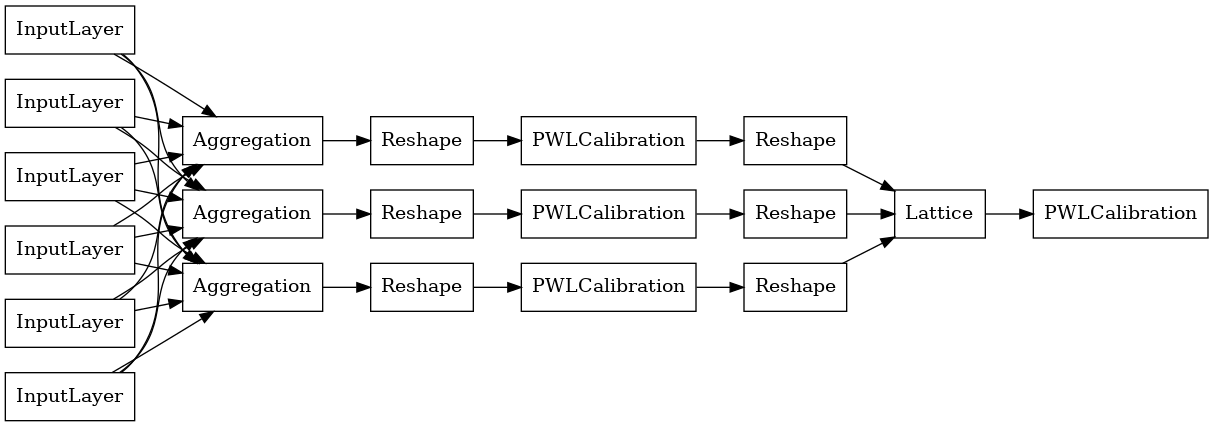

In [13]:
# Model config defines the model structure for the aggregate function model.
aggregate_function_model_config = tfl.configs.AggregateFunctionConfig(
    feature_configs=feature_configs,
    middle_dimension=MIDDLE_DIM,
    middle_lattice_size=MIDDLE_LATTICE_SIZE,
    middle_calibration=True,
    middle_calibration_num_keypoints=MIDDLE_KEYPOINTS,
    middle_monotonicity='increasing',
    output_min=min_label,
    output_max=max_label,
    output_calibration=True,
    output_calibration_num_keypoints=OUTPUT_KEYPOINTS,
    output_initialization=np.linspace(
        min_label, max_label, num=OUTPUT_KEYPOINTS))
# An AggregateFunction premade model constructed from the given model config.
aggregate_function_model = tfl.premade.AggregateFunction(
    aggregate_function_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    aggregate_function_model, show_layer_names=False, rankdir='LR')

每个聚合层的输出是已校准点阵在不规则输入上的平均输出。下面是在第一个聚合层内使用的模型：

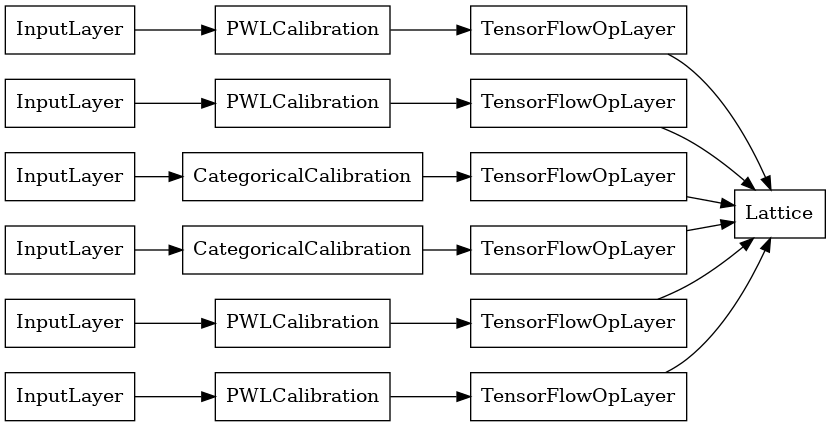

In [14]:
aggregation_layers = [
    layer for layer in aggregate_function_model.layers
    if isinstance(layer, tfl.layers.Aggregation)
]
tf.keras.utils.plot_model(
    aggregation_layers[0].model, show_layer_names=False, rankdir='LR')

现在，与任何其他 [tf.keras.Model](https://tensorflow.google.cn/api_docs/python/tf/keras/Model) 一样，我们编译该模型并将其拟合到我们的数据中。

In [15]:
aggregate_function_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
aggregate_function_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)

训练完模型后，我们可以在测试集中对其进行评估。

In [16]:
print('Test Set Evaluation...')
print(aggregate_function_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/7 [===>..........................] - ETA: 0s - loss: 133.7238

7/7 [==============================] - 0s 6ms/step - loss: 47.7708


47.77081298828125
